In [ ]:
!git clone https://github.com/RoehrichLukas/ponds_ERSU_jf_20251106
%cd ponds_ERSU_jf_20251106

In [ ]:
pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 26.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [cartopy]m4/5 [cartopy]
Note: you may need to restart the kernel to use updated packages.


# PONDS - a 'feuchtfröhliches' Coding Adventure

In [1]:
# Prerequisites
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

## Creating a PONDS object is easy!

In [2]:
from ponds.core import PONDS

lat_size = 100
lon_size = 200
time_size = 500

pd = PONDS(
    lat_size=lat_size,
    lon_size=lon_size,
    time_size=time_size,
)

#fig1, ax1 = pd.worldmap(
#    show_cells=True,
#)
#fig2, ax2 = pd.plot_all_ts()

In the plots above we can see the granularity of the world-spanning grid and an example set of the time series of some cells. The y-axis of the second plot shows the value of the arbitrary observable. As we are dealing with synthetic data, we want to leave it abstract like that. The default value is 0 and because we have not done anything with our cells yet, we only see a flat line.

## Let's fill it with some life

### Background Features


First we want to add some background features like an overall postive trend of the observable and some white noise.

In [3]:
from ponds import WhiteNoise, Trend

background_noise = 0.05
background_trend = 0.002
background_intercept = 2.5
time_size = 200

pd.add_background(
    background_method=WhiteNoise(
        magnitude=background_noise,
        background_seed=1,
    )
)
pd.add_background(
    background_method=Trend(
        slope=background_trend,
        intercept=background_intercept,
    )
)

#fig2, ax2 = pd.plot_all_ts()

### Adding Shift Events

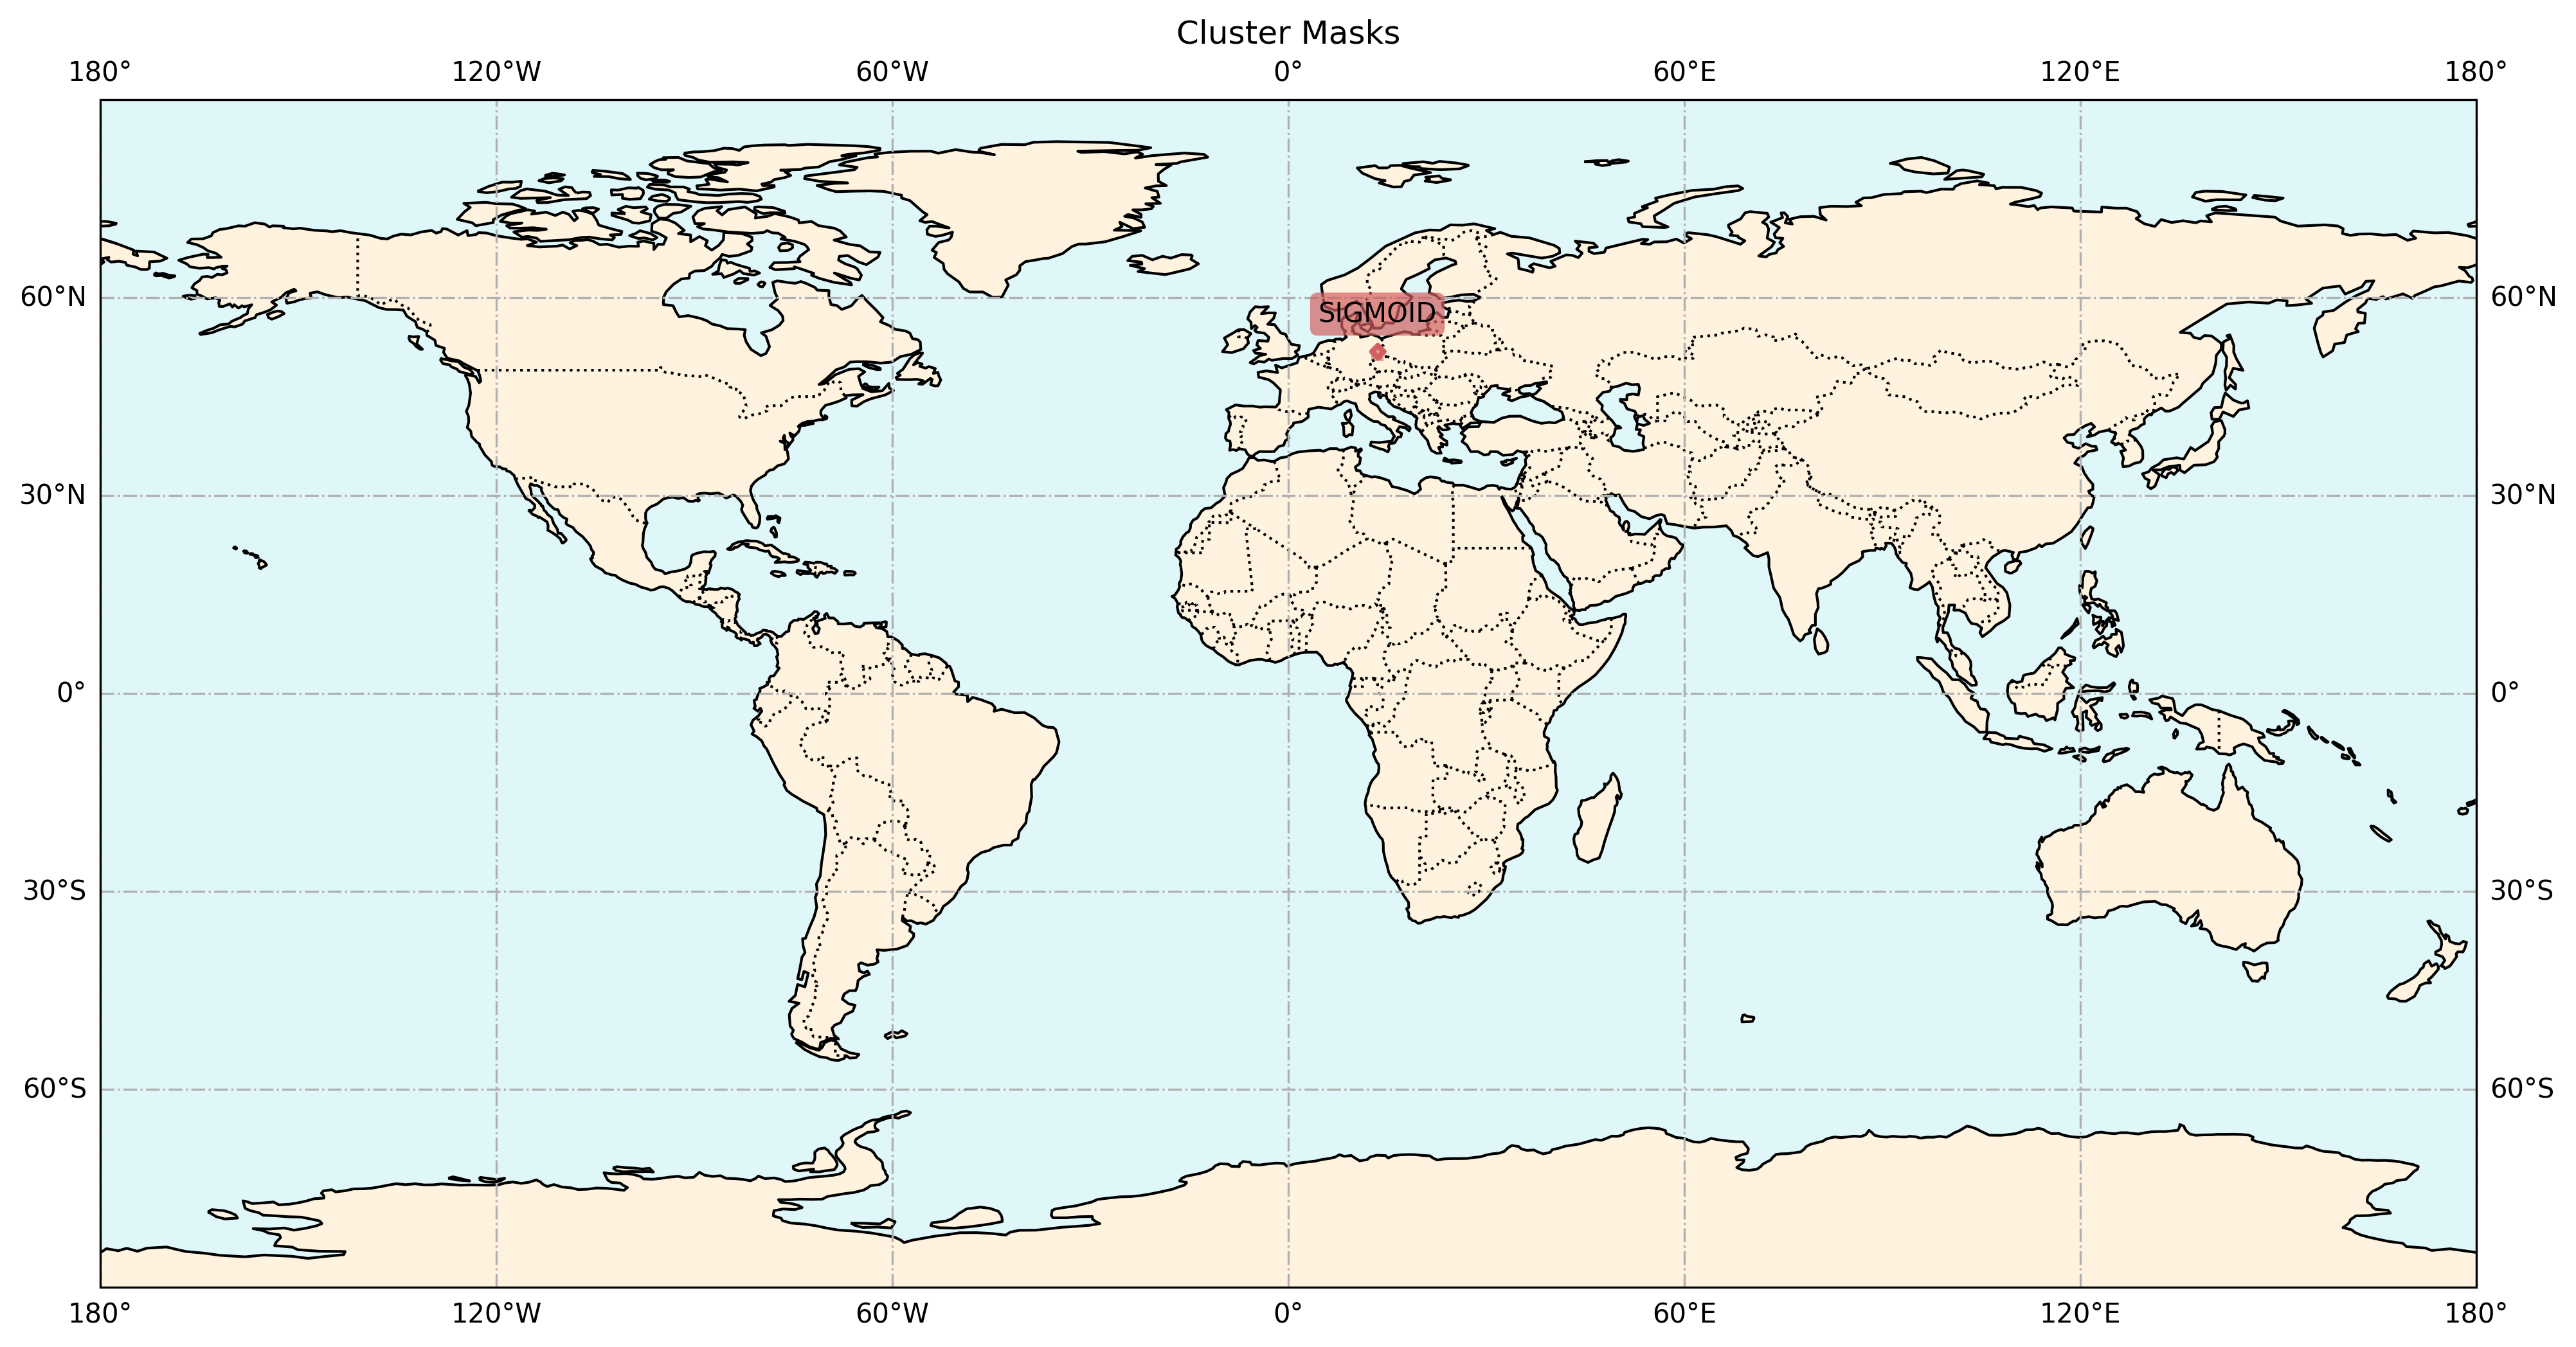

In [4]:
from ponds import SIGMOID, CELL

center_lat = 52.5
center_lon = 13.5
central_time = 100

pd.add_shift(
    shape_method=CELL(
        center_lat=center_lat,
        center_lon=center_lon,
    ),
    shift_method=SIGMOID(
        central_time=100,
        shift_seed=1,
    ),
)

fig1, ax1 = pd.worldmap(
    shift_type=True,
)
#fig2, ax2 = pd.plot_all_ts()

The little dot in central Europe is the single cell we added a shift event to. In the second plot, we can see the shift event at the given central time.

---

This single-cell shift event is very localized and rather unrealistic. So we want to add a shift event, mimicking a more realistic scenario:

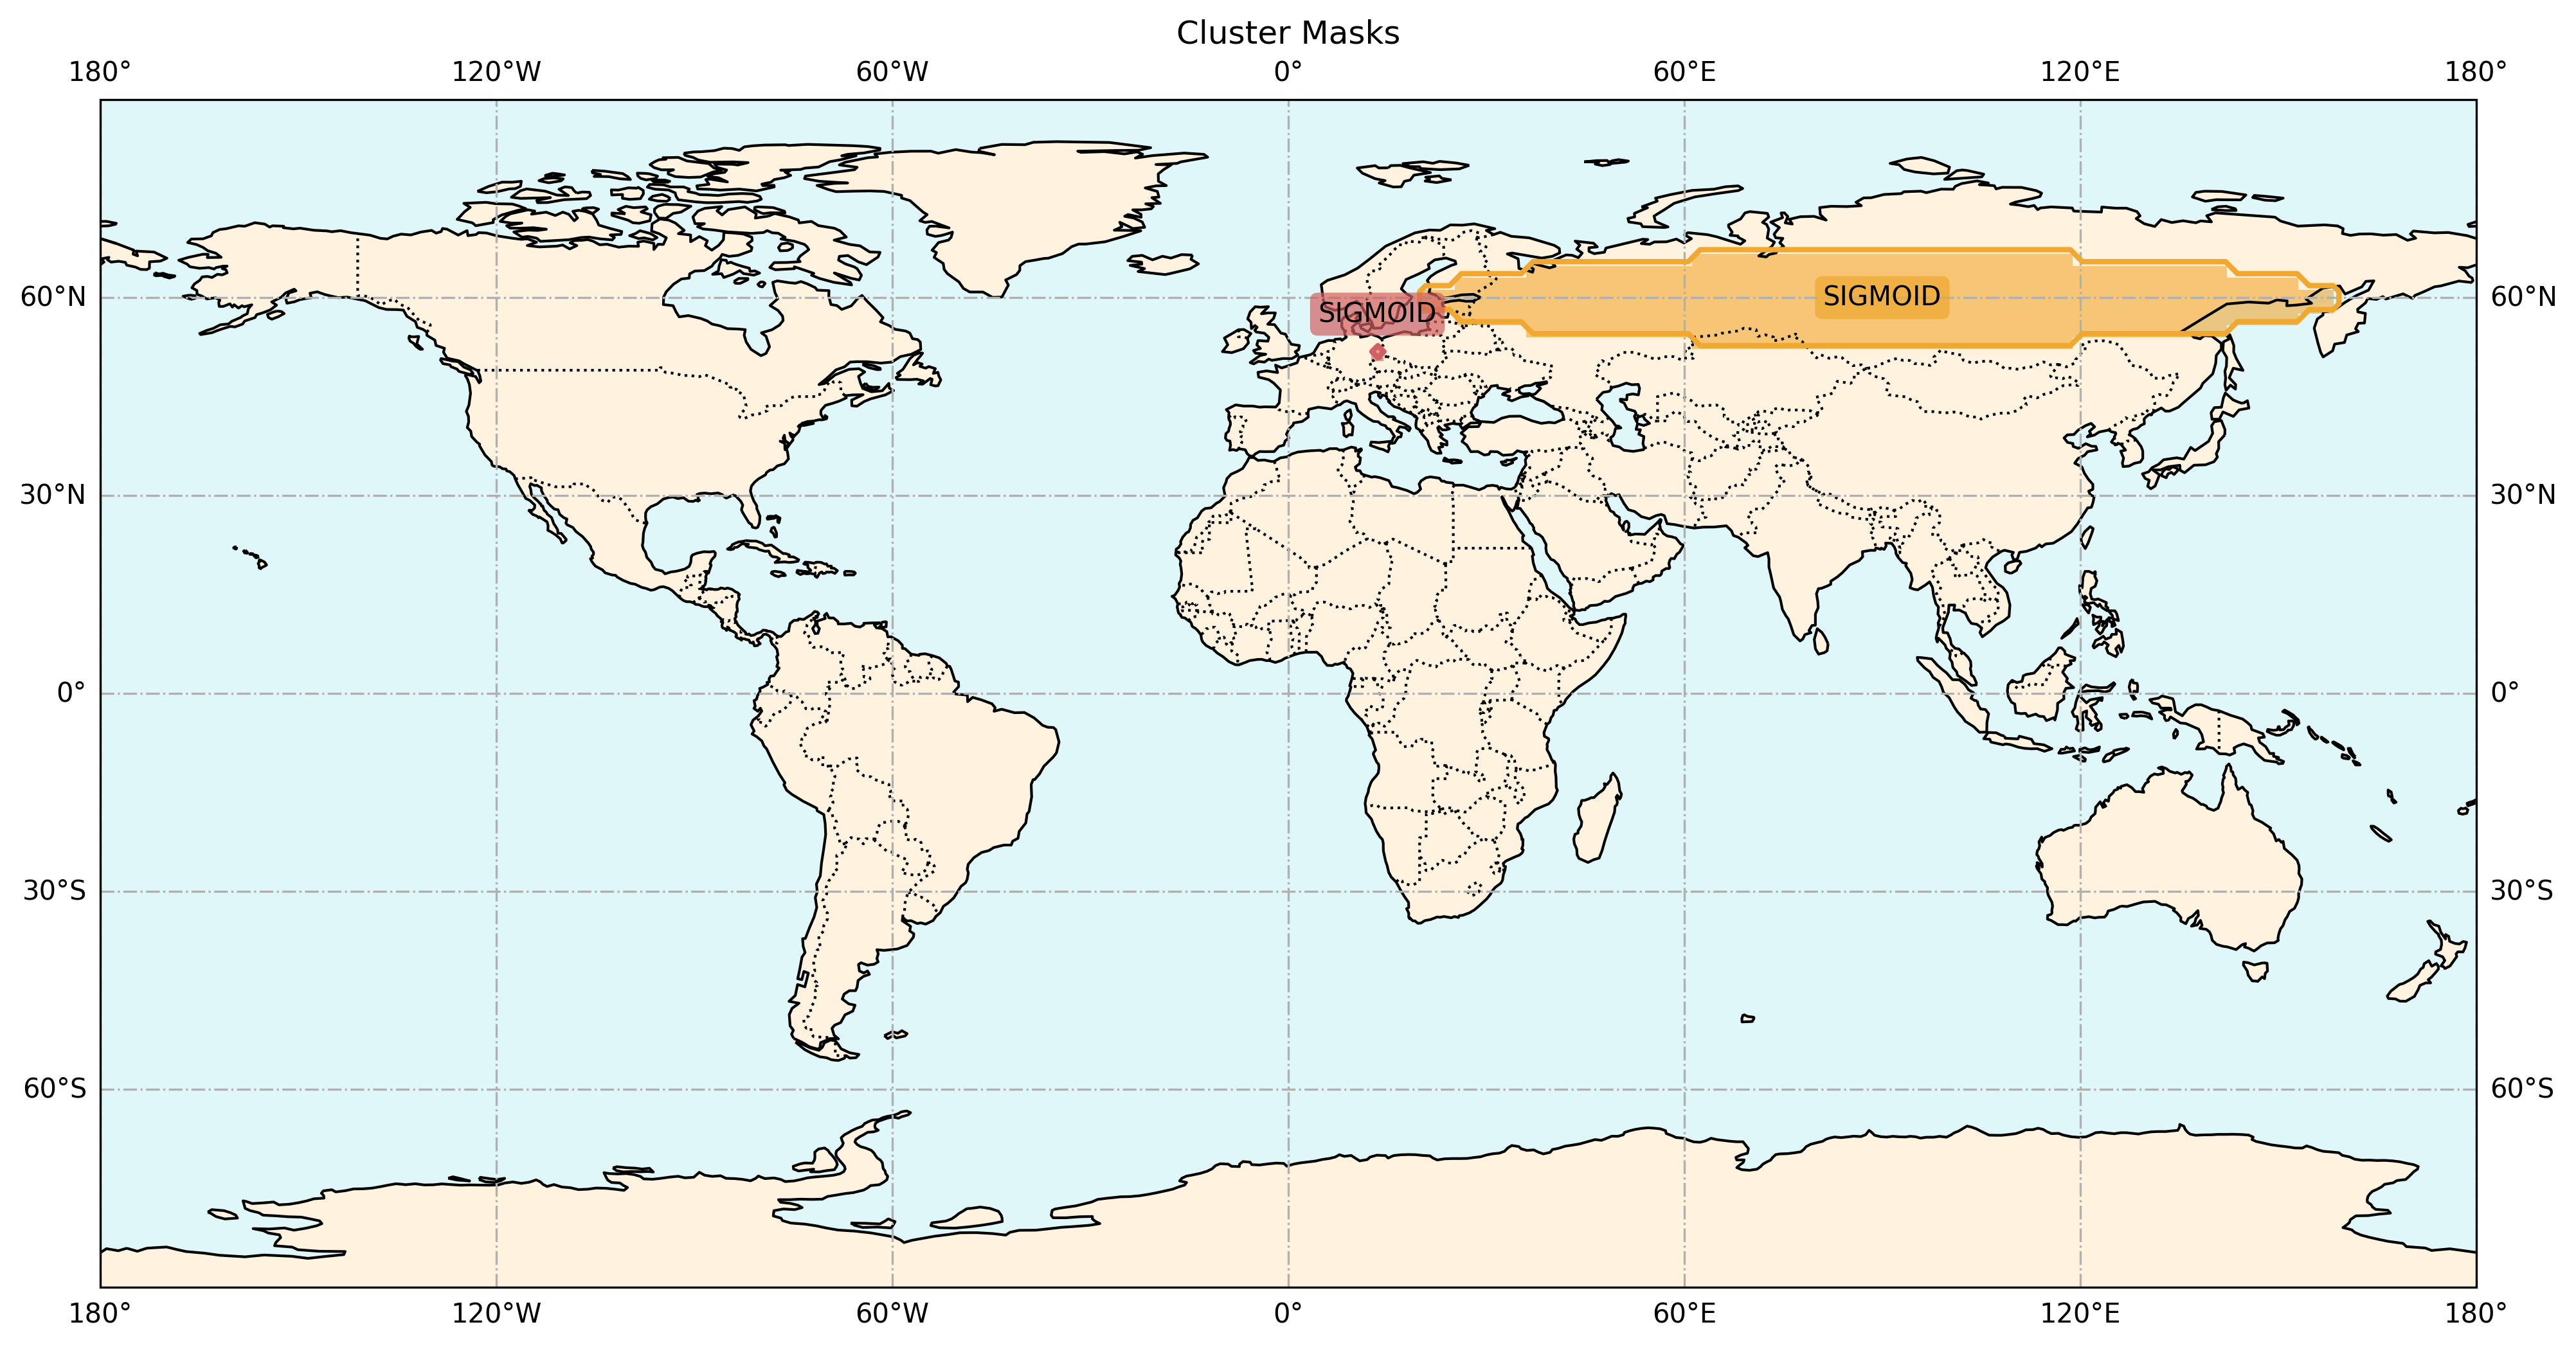

In [5]:
from ponds.shapegen import ELLIPSIS
from ponds.shiftgen import SIGMOID

center_lat = 60
center_lon = 90
ecc_lat = 7
ecc_lon = 70
central_time = 150

pd.add_shift(
    shape_method=ELLIPSIS(
        center_lat=center_lat,
        center_lon=center_lon,
        ecc_lat=ecc_lat,
        ecc_lon=ecc_lon,
    ),
    shift_method=SIGMOID(
        central_time=central_time,
        shift_magnitude=-0.5,
        shift_seed=1,
    ),
)

fig1, ax1 = pd.worldmap(
    shift_type=True,
)
#fig2, ax2 = pd.plot_all_ts()

---



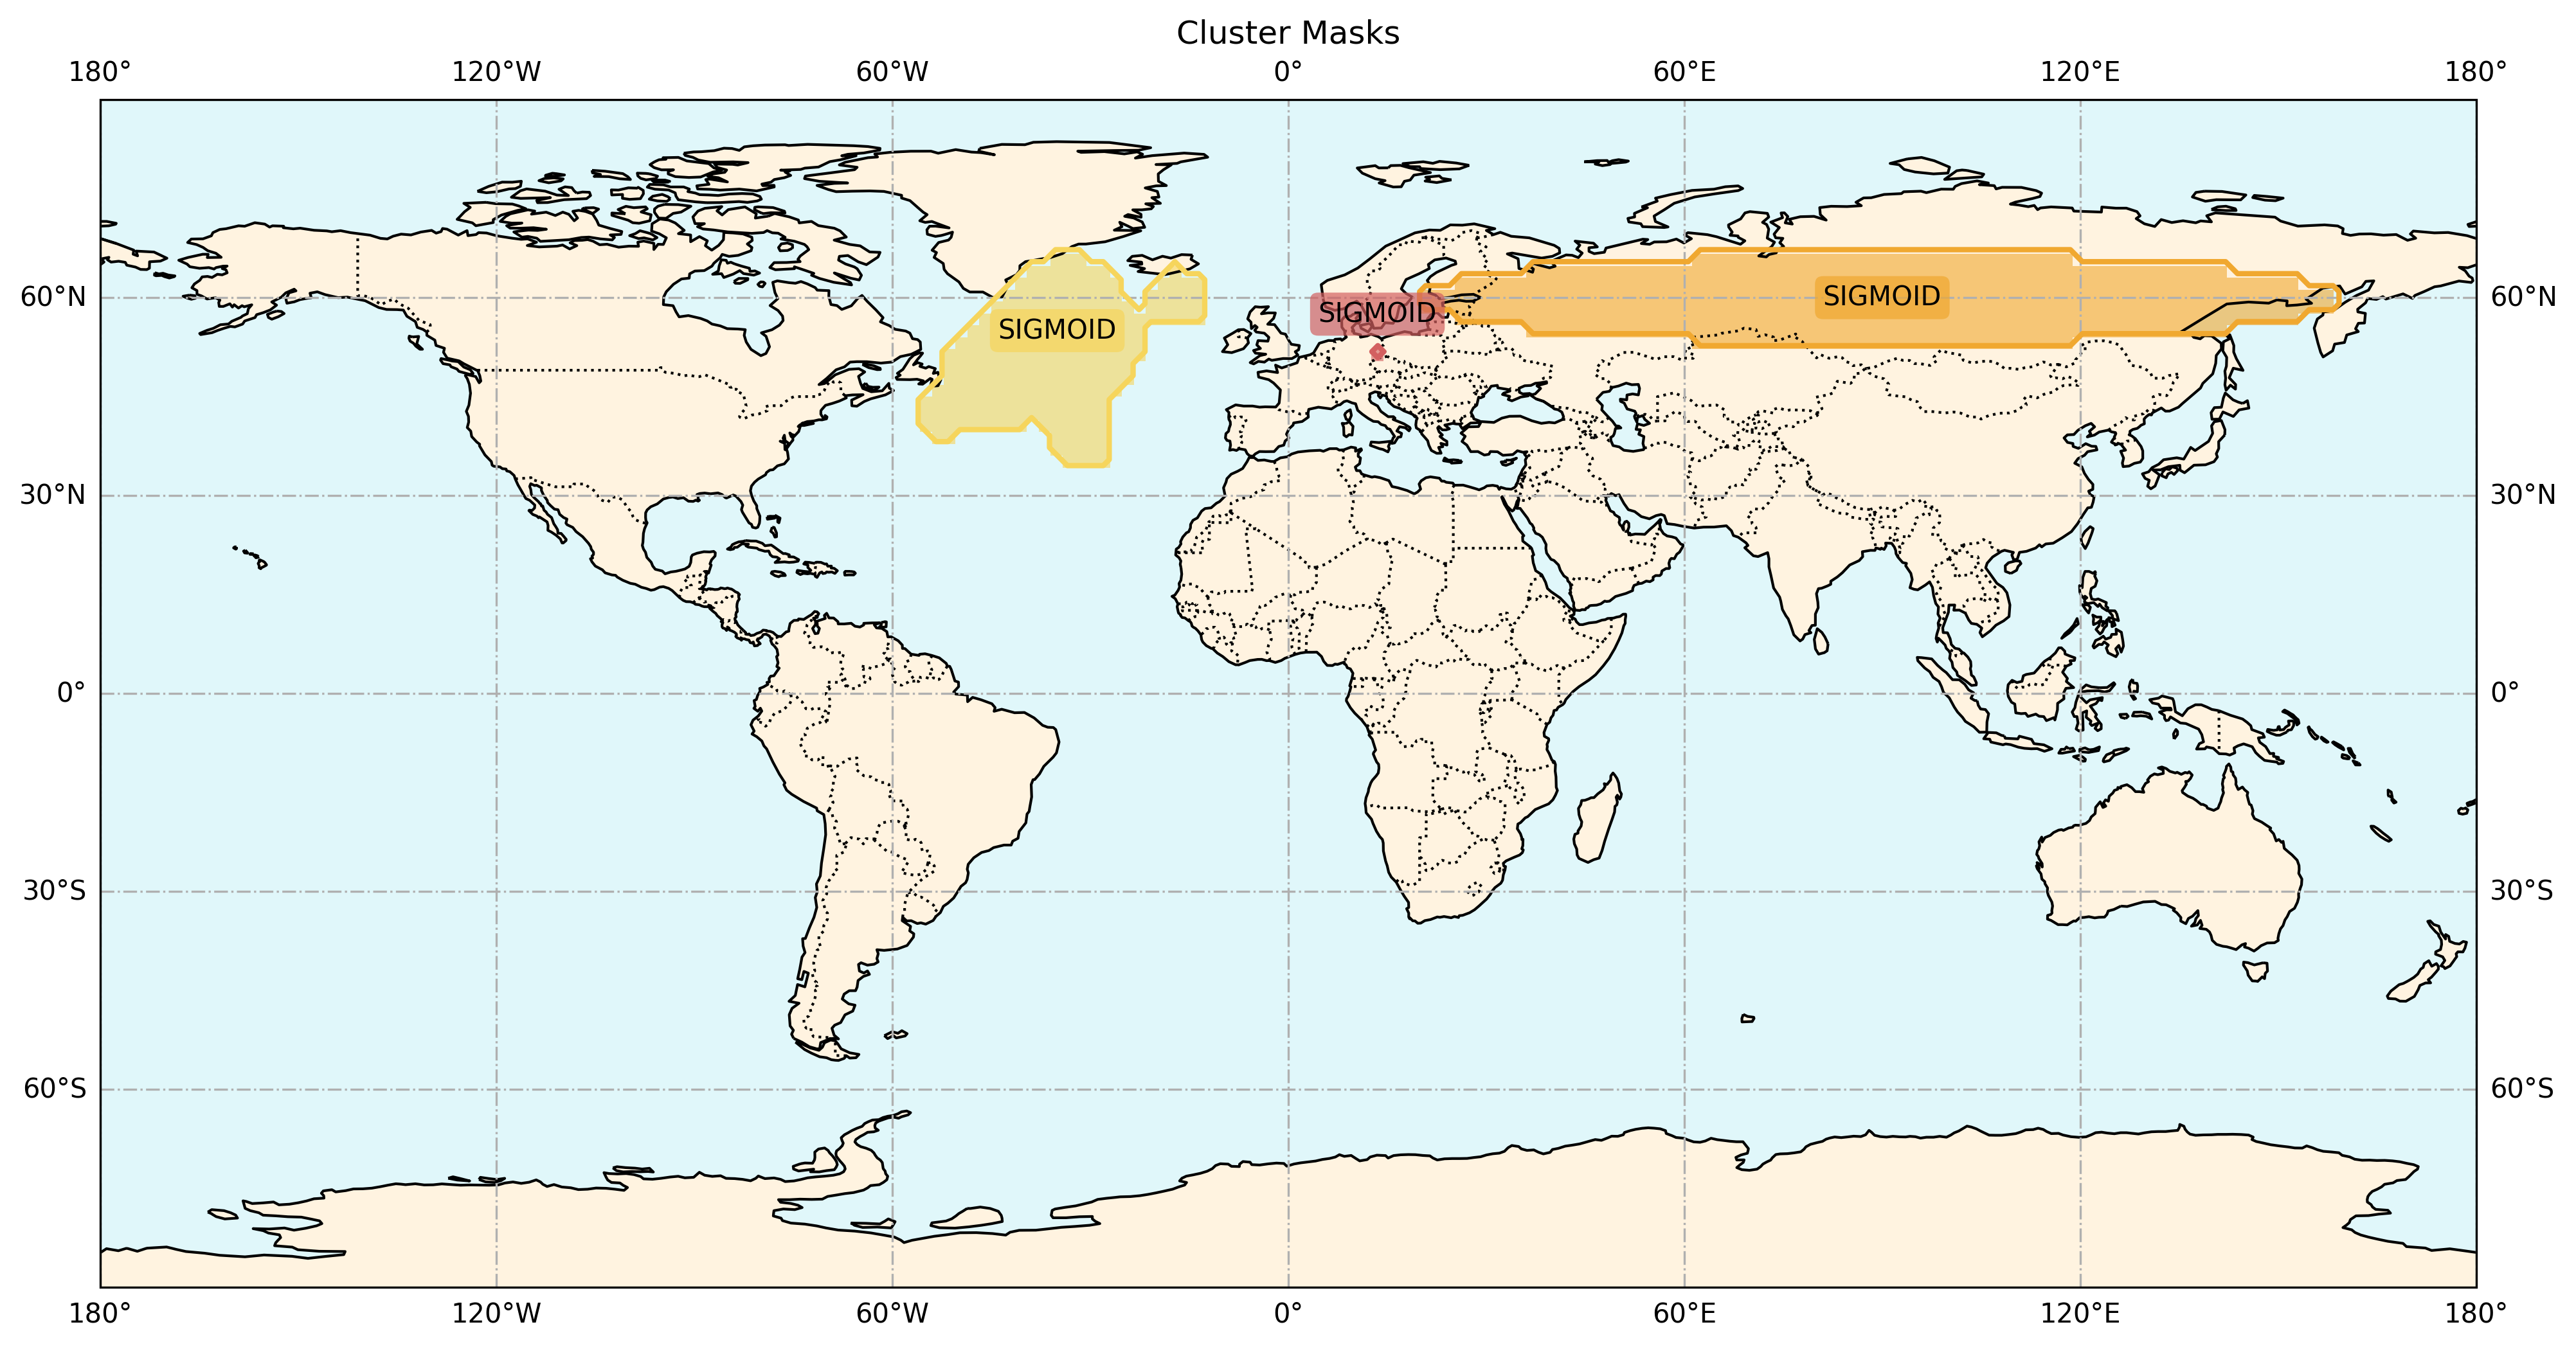

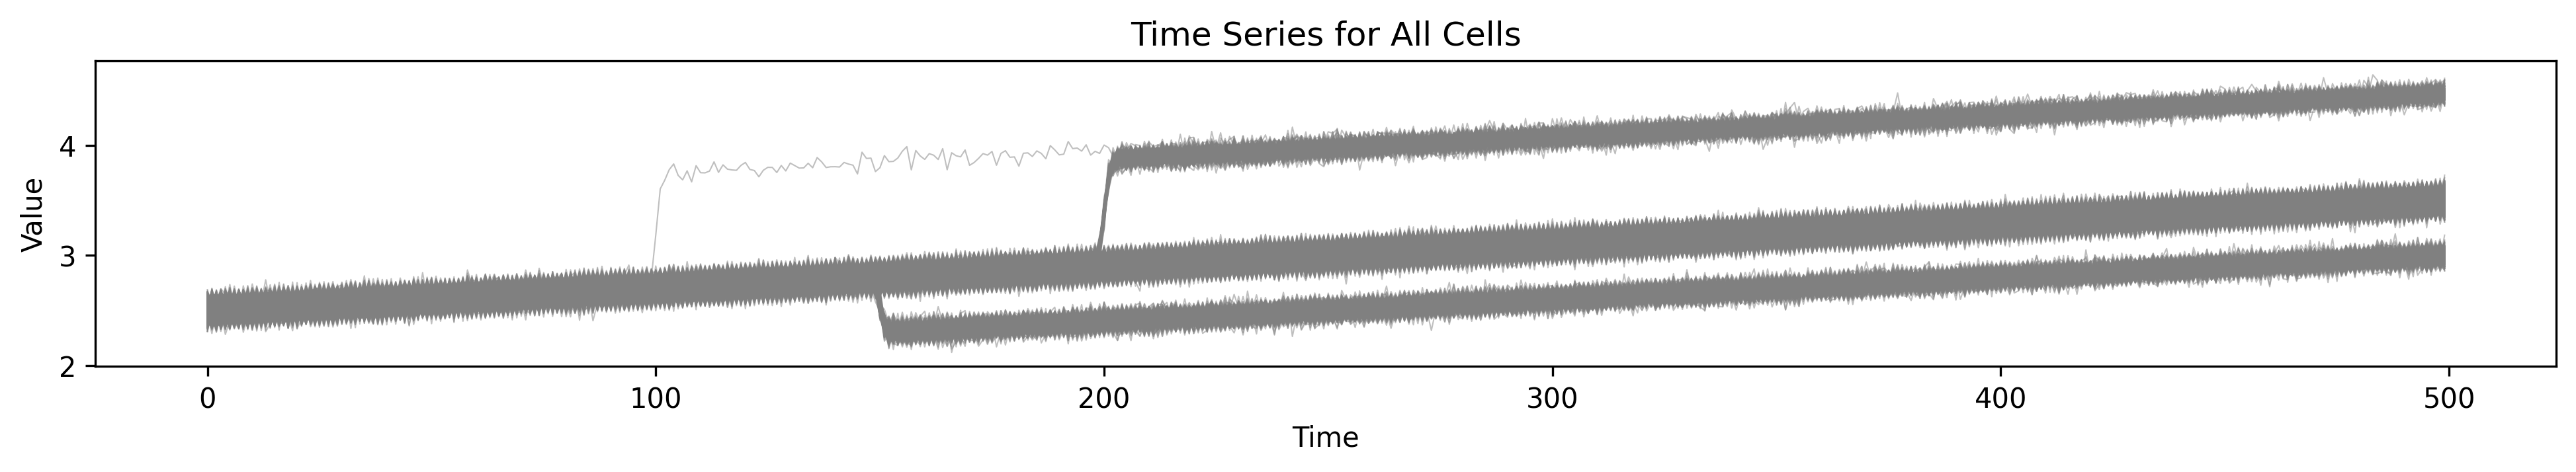

In [6]:
from ponds.shapegen import BLOB

center_lat = 55
center_lon = -35
size = 4
shape_seed = 2
central_time = 200

pd.add_shift(
    shape_method=BLOB(
        center_lat=center_lat,
        center_lon=center_lon,
        size=size,
        shape_seed=shape_seed,
    ),
    shift_method=SIGMOID(
        shift_seed=3,
        central_time=central_time,
    )
)

fig1, ax1 = pd.worldmap(
    shift_type=True,
)
fig2, ax2 = pd.plot_all_ts()

### Time Correlation

PONDS even allows temporal correlation within a shift cluster mask by using `correlation_methods`. This means, that different cells shift at different steps which indicates a propagation of the shift event due to external factors.

The next cells visualizes these correlation methods exemplary:

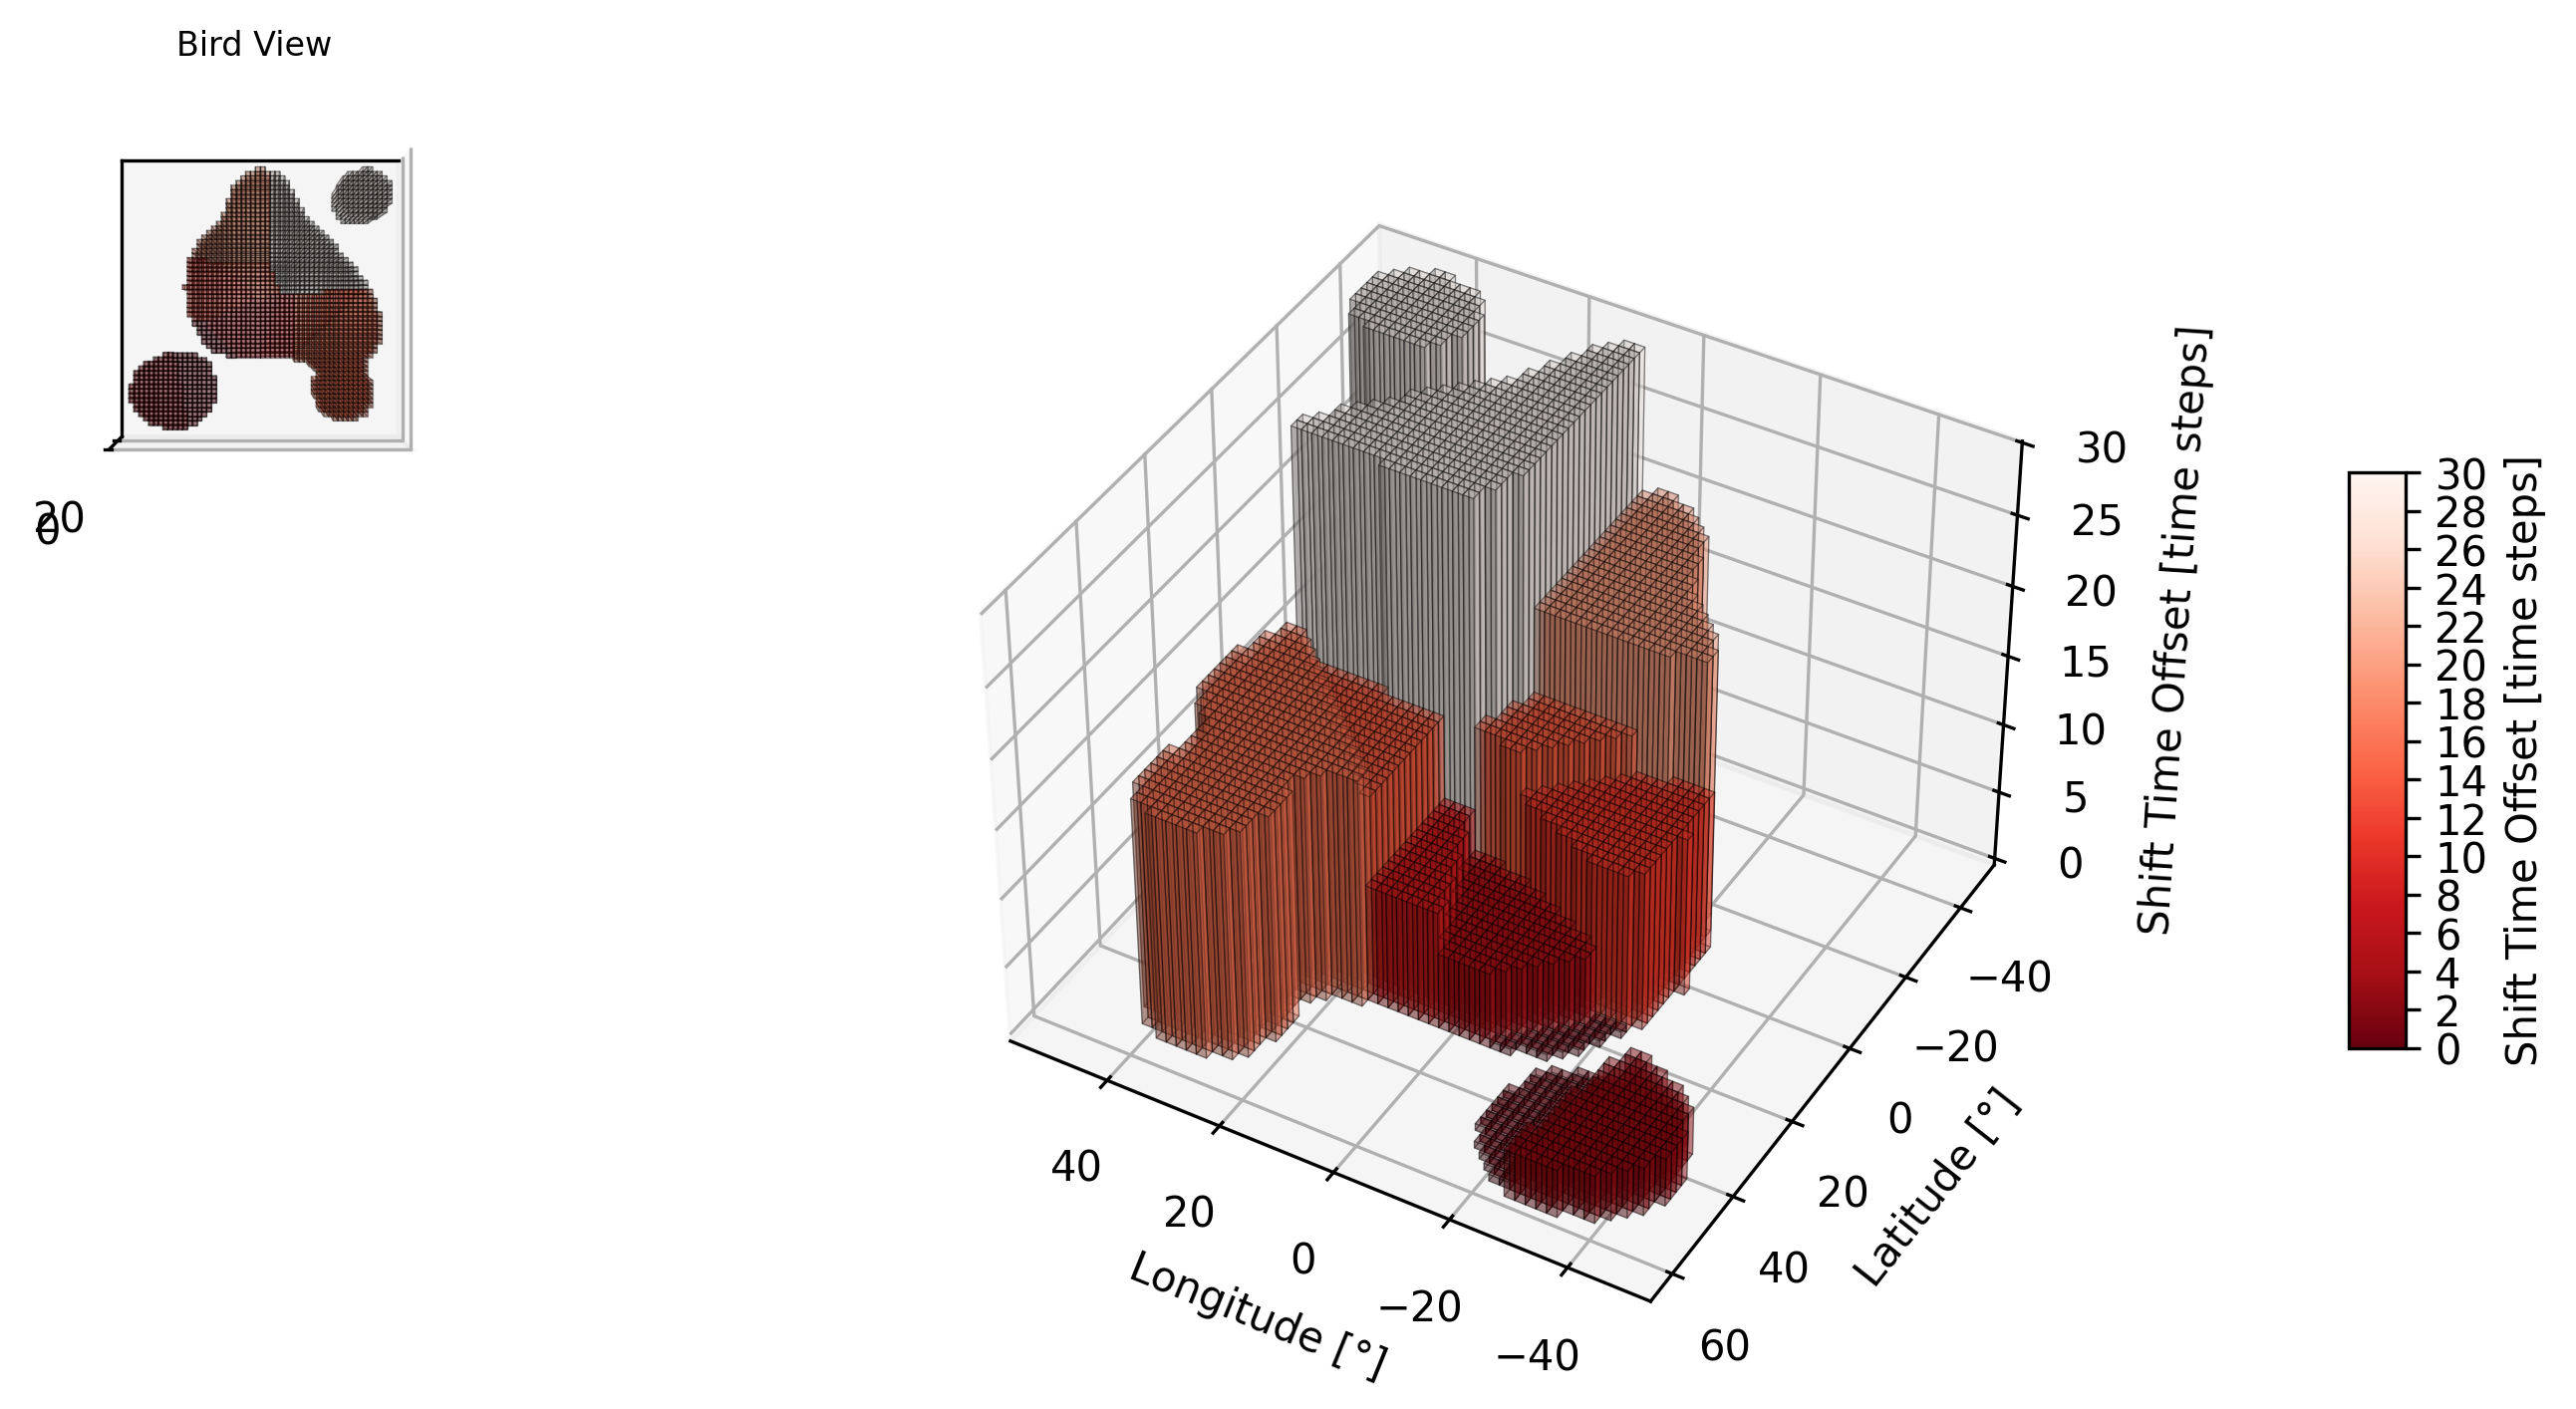

In [ ]:
from ponds.shapegen import BLOB
from ponds.correlationgen import Propagating, Gauss, Noise, Custom  # <- all the available correlation types
from ponds.plotter import barplot_3D

lat_size = 101
lon_size = 201
lats = np.linspace(-90, 90, lat_size)
lons = np.linspace(-180, 180, lon_size)

# Create a mask with a blob shape
cluster = BLOB(
    center_lat=0,
    center_lon=0,
    shape_seed=10,
    size=10,
    goo=1.95,
)
cluster_mask = cluster.make_shape(lats=lats, lons=lons)

corr = Propagating(     # <- ToDo: change this block to another correlation type to see different results
    n_cells=10,             # number of voronoi cells within cluster mask
    corr_seed=3,            # random seed for reproducibility
    max_offset=30,          # maximum time offset
)

#corr = Gauss(
#    corr_center_lat=0,      # latitude of the gaussian peak
#    corr_center_lon=0,      # longitude of the gaussian peak
#    sigma_lat=20,           # gauss standard deviation in latitude
#    sigma_lon=20,           # gauss standard deviation in longitude
#    max_offset=30,          # maximum time offset
#)

shift_times = corr.make_time_offsets(
    cluster_mask,
)

fig, ax = barplot_3D(
    cluster_mask,
    lons,
    lats,
    shift_times,
    alpha=0.3,
    cmap="Reds_r",
)

Let's see how we can add these correlation features to a PONDS. In the cell below we create a completely new PONDS object and use the `Gauss` correlation method to add some underlying structure.

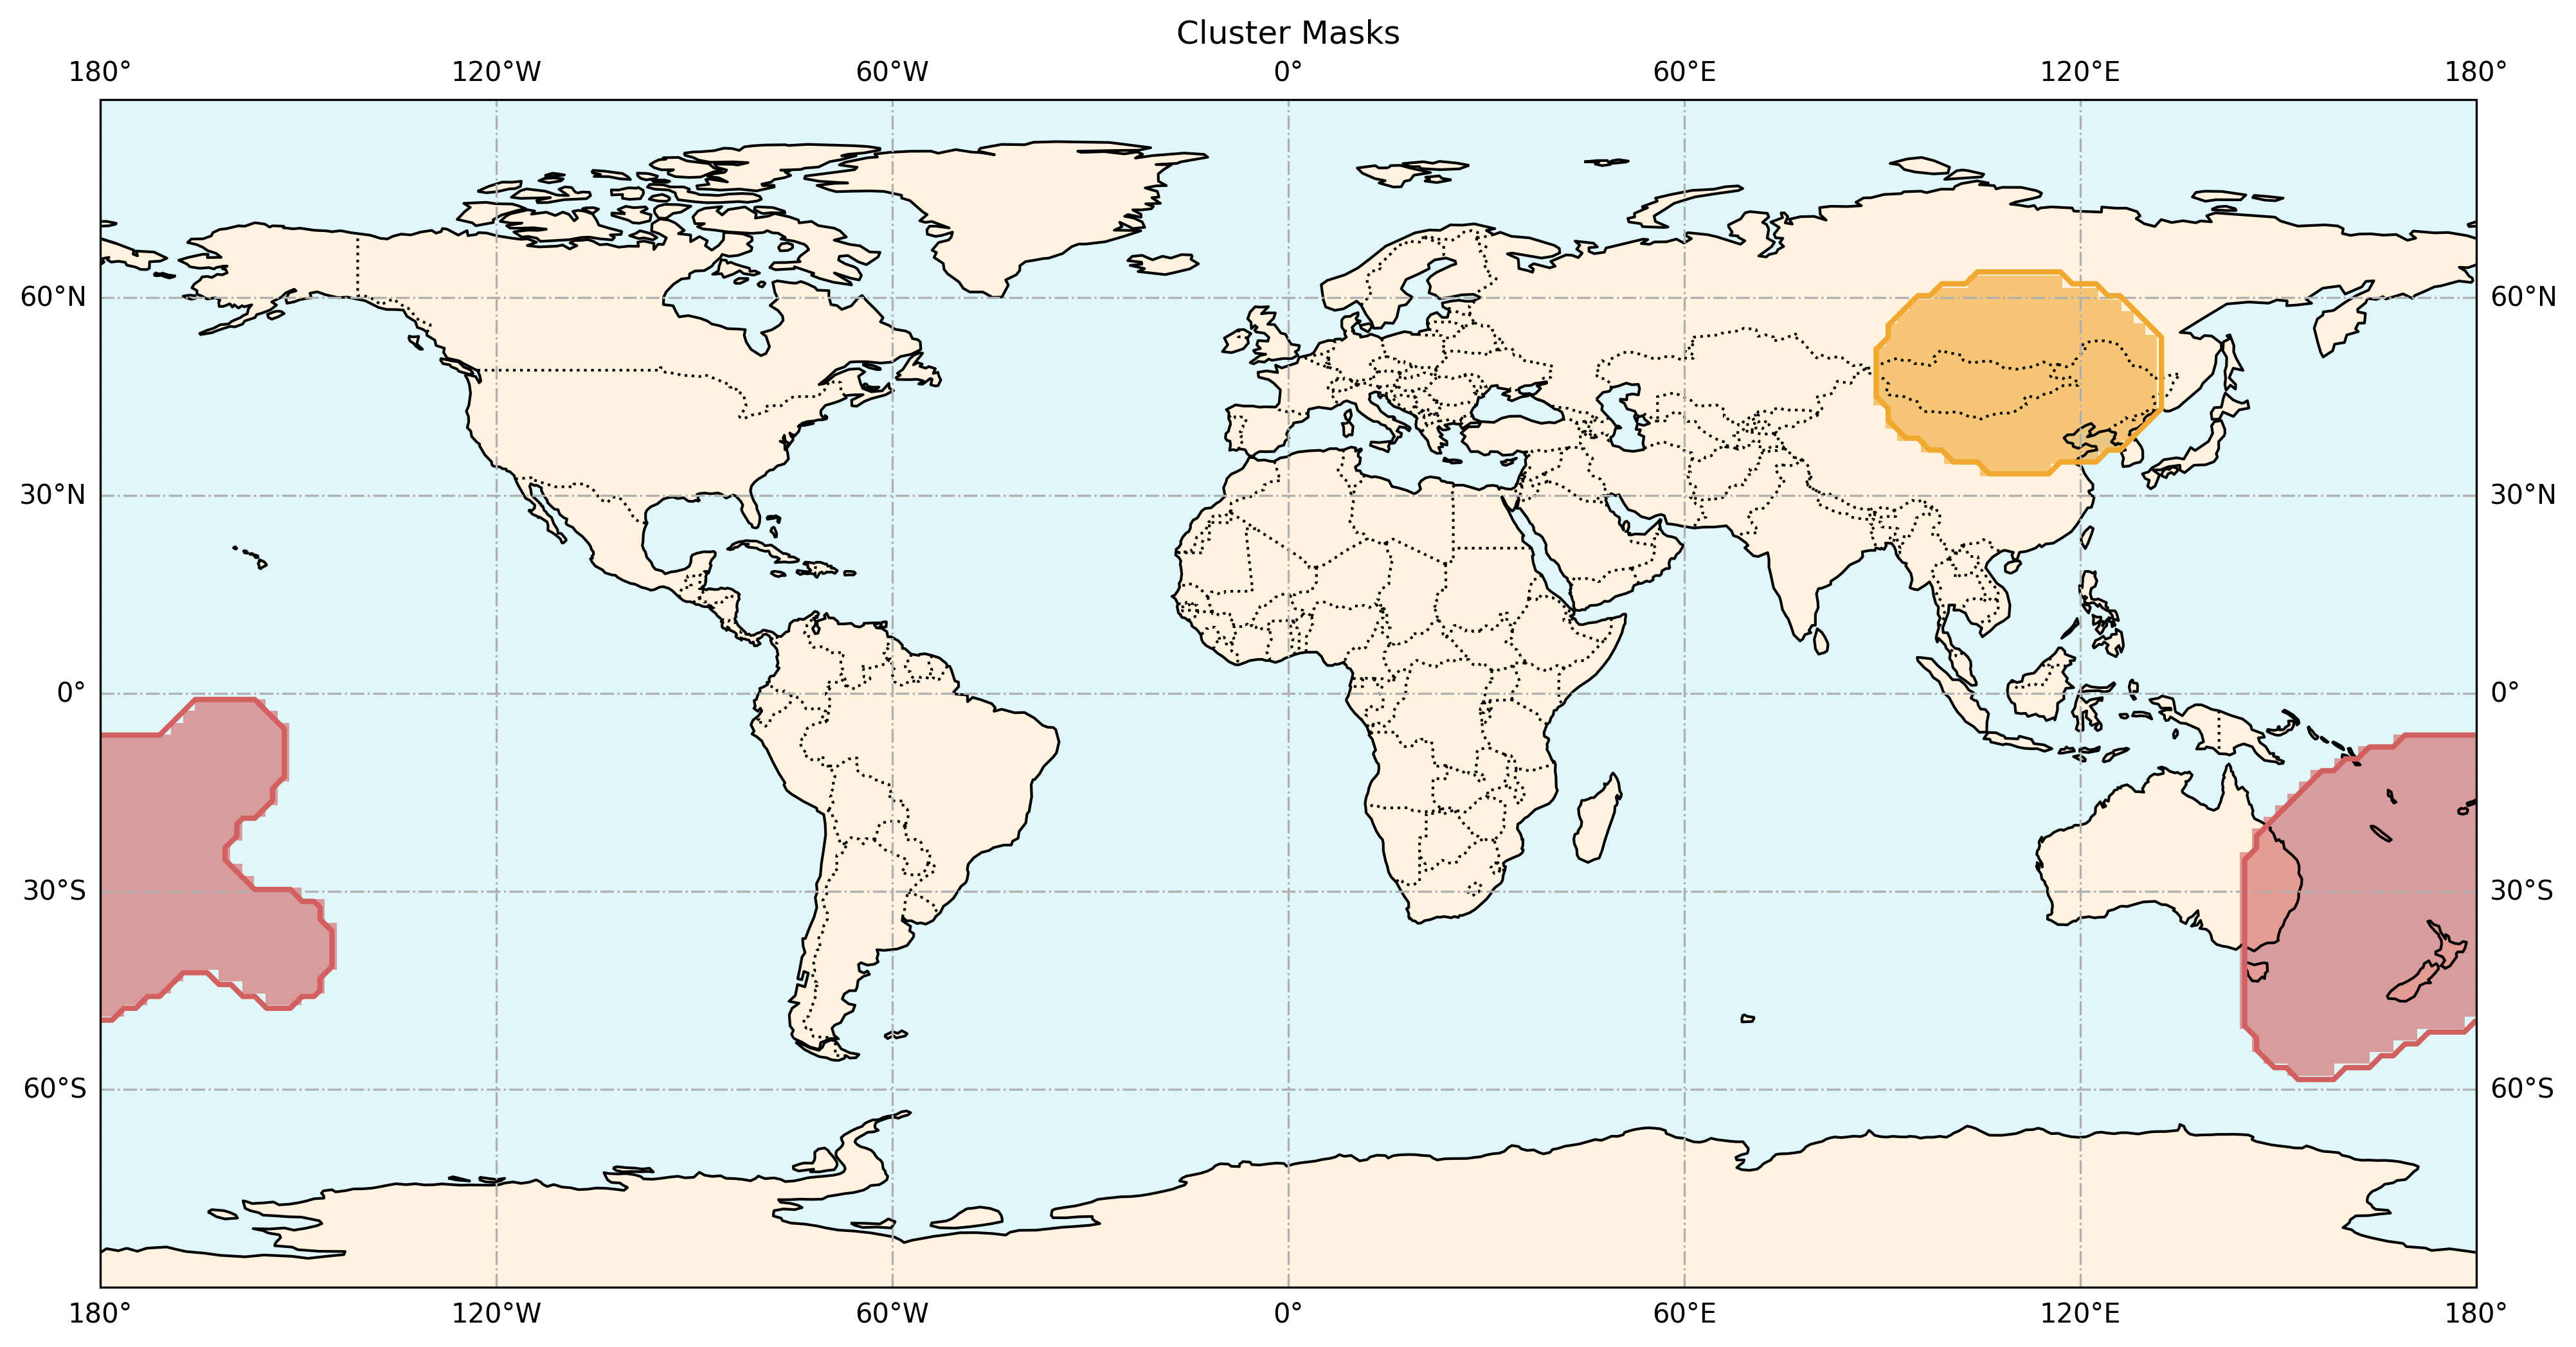

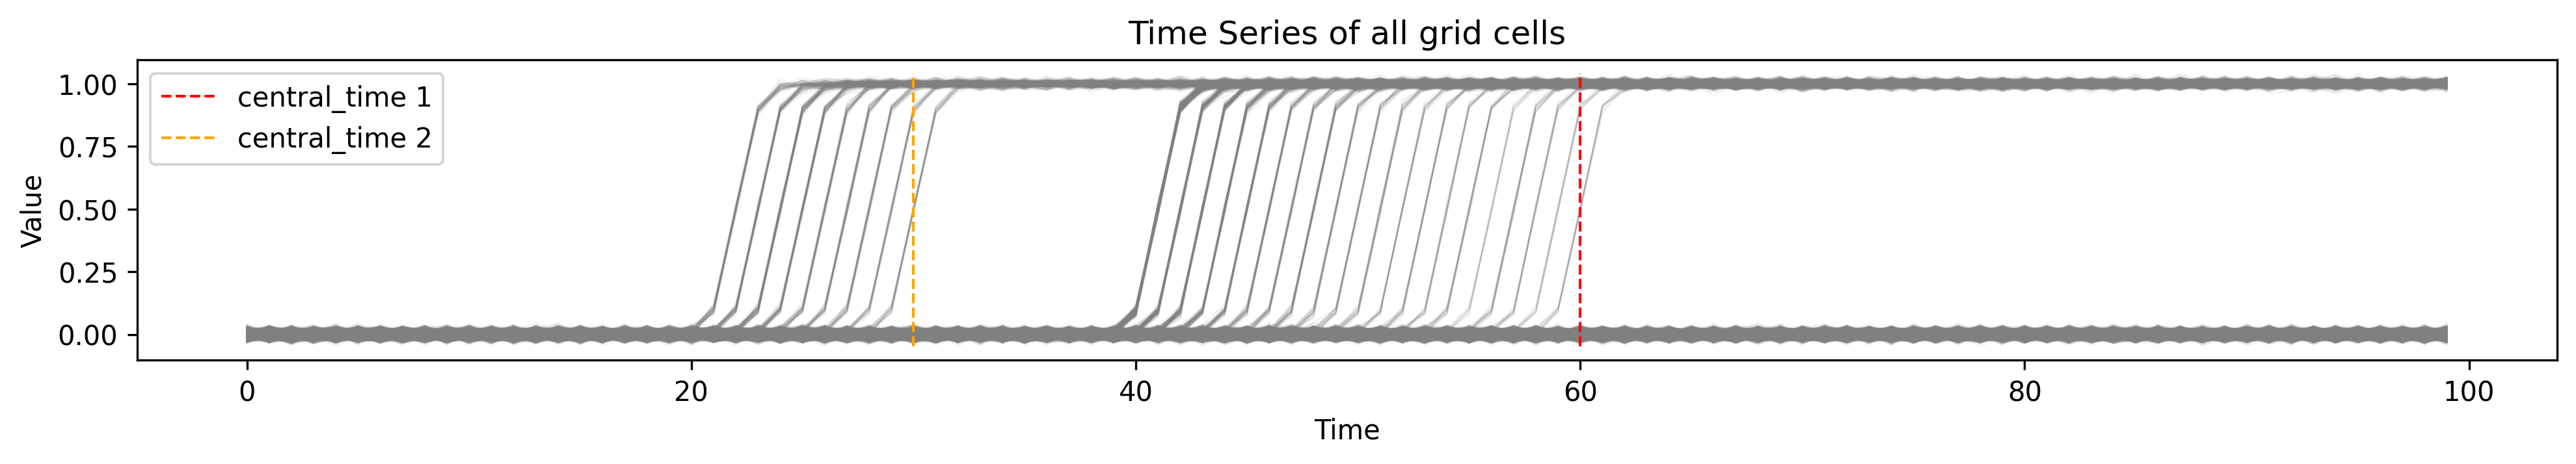

In [7]:
from ponds.correlationgen import Gauss

central_time_1 = 60
max_offset_1 = 20
central_time_2 = 30
max_offset_2 = 10

pd = PONDS(
    lat_size=101,
    lon_size=201,
    time_size=100,
)

pd.add_background(
    background_method=WhiteNoise(
        magnitude=0.01,
        background_seed=1,
    )
)

pd.add_shift(
    shift_method=SIGMOID(
        central_time=central_time_1,
        shift_magnitude=1,
    ),
    shape_method=BLOB(
        shape_seed=8,
    ),
    correlation_method=Gauss(
        max_offset=max_offset_1,
    ),
)

pd.add_shift(
    shift_method=SIGMOID(
        central_time=central_time_2,
        shift_magnitude=1,
    ),
    shape_method=ELLIPSIS(
        shape_seed=5,
    ),
    correlation_method=Gauss(
        max_offset=max_offset_2,
    ),
)

fig1, ax1 = pd.worldmap()

fig2, ax2 = pd.plot_all_ts(
    alpha=0.1,
)

ax2.vlines(
    x=central_time_1,
    ymin=np.min(pd.data.ts),
    ymax=np.max(pd.data.ts),
    linestyle="--",
    linewidth=1,
    color="red",
    label="central_time 1",
)
ax2.vlines(
    x=central_time_2,
    ymin=np.min(pd.data.ts),
    ymax=np.max(pd.data.ts),
    linestyle="--",
    linewidth=1,
    color="orange",
    label="central_time 2",
)
ax2.set_title("Time Series of all grid cells")
ax2.legend(loc="upper left")

plt.show()

## List of Methods

<table>
  <tr>
    <th>Method</th>
    <th>Name</th>
    <th>Description</th>
    <th>Parameters</th>
  </tr>

  <!-- Background -->
  <tr>
    <td rowspan="2">Backgrounds</td>
    <td>WhiteNoise</td>
    <td>Add some white noise to the time series</td>
    <td>- magnitude<br>- background_seed</td>
  </tr>
  <tr>
    <td>Trend</td>
    <td>Add a trend to the time series.</td>
    <td>- slope<br>- intercept</td>
  </tr>

  <!-- Shape -->
  <tr>
    <td rowspan="6">Shapes</td>
    <td>SINGLE</td>
    <td>Default!<br>Mask spanning all the grid cells.<br>All cells are treated like a single one.</td>
    <td>-</td>
  </tr>
  <tr>
    <td>CELL</td>
    <td>Mask for a single grid cell.</td>
    <td>- center_lat<br>- center_lon</td>
  </tr>
  <tr>
    <td>ELLIPSIS</td>
    <td>Elliptic shape mask</td>
    <td>- center_lat<br>- center_lon<br>- ecc_lat<br>- ecc_lon<br>- shape_seed</td>
  </tr>
  <tr>
    <td>CUSTOM</td>
    <td>Custom shape mask by providing<br>a boolean mask.</td>
    <td>- shape_mask</td>
  </tr>
  <tr>
    <td>BLOB</td>
    <td>Funny looking blob consiting of <br>several balls stuck together<br>like a gooe liquid.</td>
    <td>- center_lat<br>- center_lon<br>- size<br>- max_bellys<br>- goo<br>- shape_seed</td>
  </tr>
  <tr>
    <td>CLUSTER</td>
    <td>Mask of unattached local shift clusters.</td>
    <td>- center_lat<br>- center_lon<br>- size_lat<br>- size_lon<br>- n<br>- mode<br>- shape_seed</td>
  </tr>

  <!-- Shift -->
  <tr>
    <td rowspan="2">Shifts</td>
    <td>SIGMOID</td>
    <td>Sigmoid like shift. Sudden change in value.</td>
    <td>- central_time<br>- shift_steepness<br>- shift_magnitude<br>- shift_seed</td>
  </tr>
  <tr>
    <td>BIMODAL</td>
    <td>Alternating between two states.</td>
    <td>- central_time<br>- Interval_length<br>- duration<br>- shift_magnitude<br>- shift_seed</td>
  </tr>

  <!-- Correlation -->
  <tr>
    <td rowspan="5">Correlations</td>
    <td>NoCorr</td>
    <td>Default!<br>No Correlation between cluster cells.</td>
    <td>-</td>
  </tr>
  <tr>
    <td>Noise</td>
    <td>Noisy correlation.</td>
    <td>- max_offset<br>- corr_seed</td>
  </tr>
  <tr>
    <td>Gauss</td>
    <td>Gauss-like correlation between cluster cells.</td>
    <td>- corr_center_lat<br>- corr_center_lon<br>- sigma_lat<br>- sigma_lon<br>- max_offset</td>
  </tr>
  <tr>
    <td>Custom</td>
    <td>Custom correlation by providing<br>an integer-array of map-dimensions.</td>
    <td>- offset_mask</td>
  </tr>
  <tr>
    <td>Propagating</td>
    <td>Shift cluster is split in Voronoi Cells.<br>Shift event propagates from neighbouring<br>cell to cell.</td>
    <td>- n_cells<br>- max_offset<br>- corr_seed</td>
  </tr>
</table>
